<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [51]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [53]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/kaggle/input/magic/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [54]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [55]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [56]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [57]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [58]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

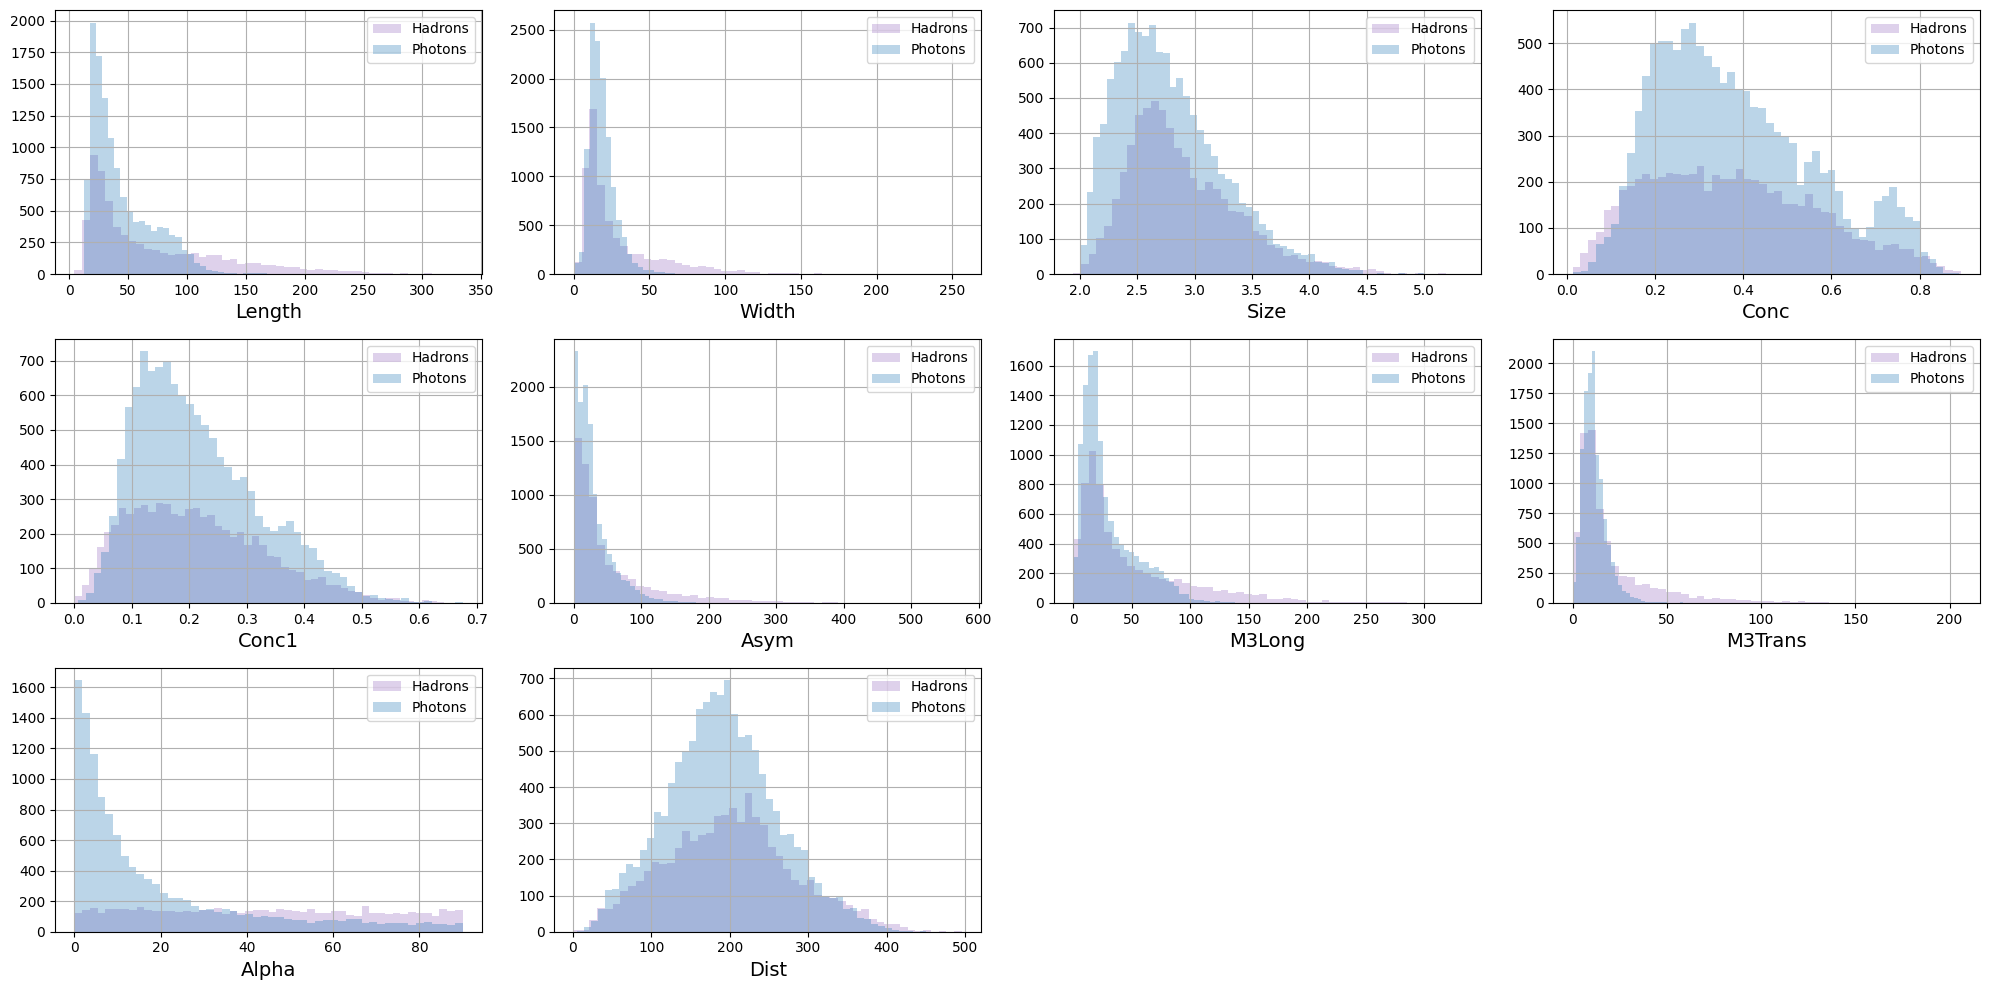

In [59]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [60]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

<Axes: title={'center': 'Train "y" distribution'}, xlabel='Class', ylabel='Count'>

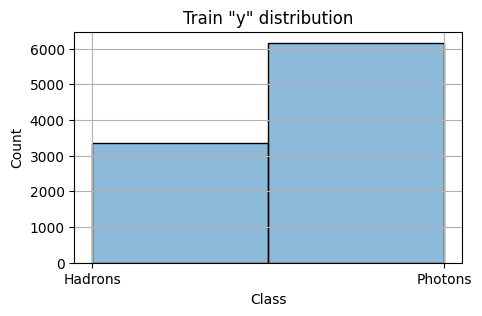

In [61]:
plt.figure(figsize=(5,3))
plt.title('Train "y" distribution')
plt.xticks([0, 1], ['Hadrons', 'Photons'])
plt.xlabel('Class')
plt.grid()
sns.histplot(data=y_train , bins=2, legend=False)

<Axes: title={'center': 'Train "y" distribution'}, xlabel='Class', ylabel='Count'>

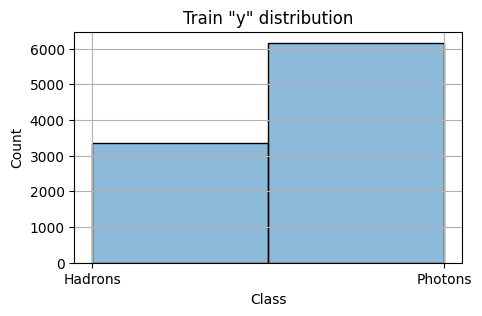

In [62]:
plt.figure(figsize=(5,3))
plt.title('Train "y" distribution')
plt.xticks([0, 1], ['Hadrons', 'Photons'])
plt.xlabel('Class')
plt.grid()
sns.histplot(data=y_test , bins=2, legend=False)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [63]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(random_state=40, output_distribution='normal')

In [64]:
### YOUR CODE IS HERE ######
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)
### THE END OF YOUR CODE ###

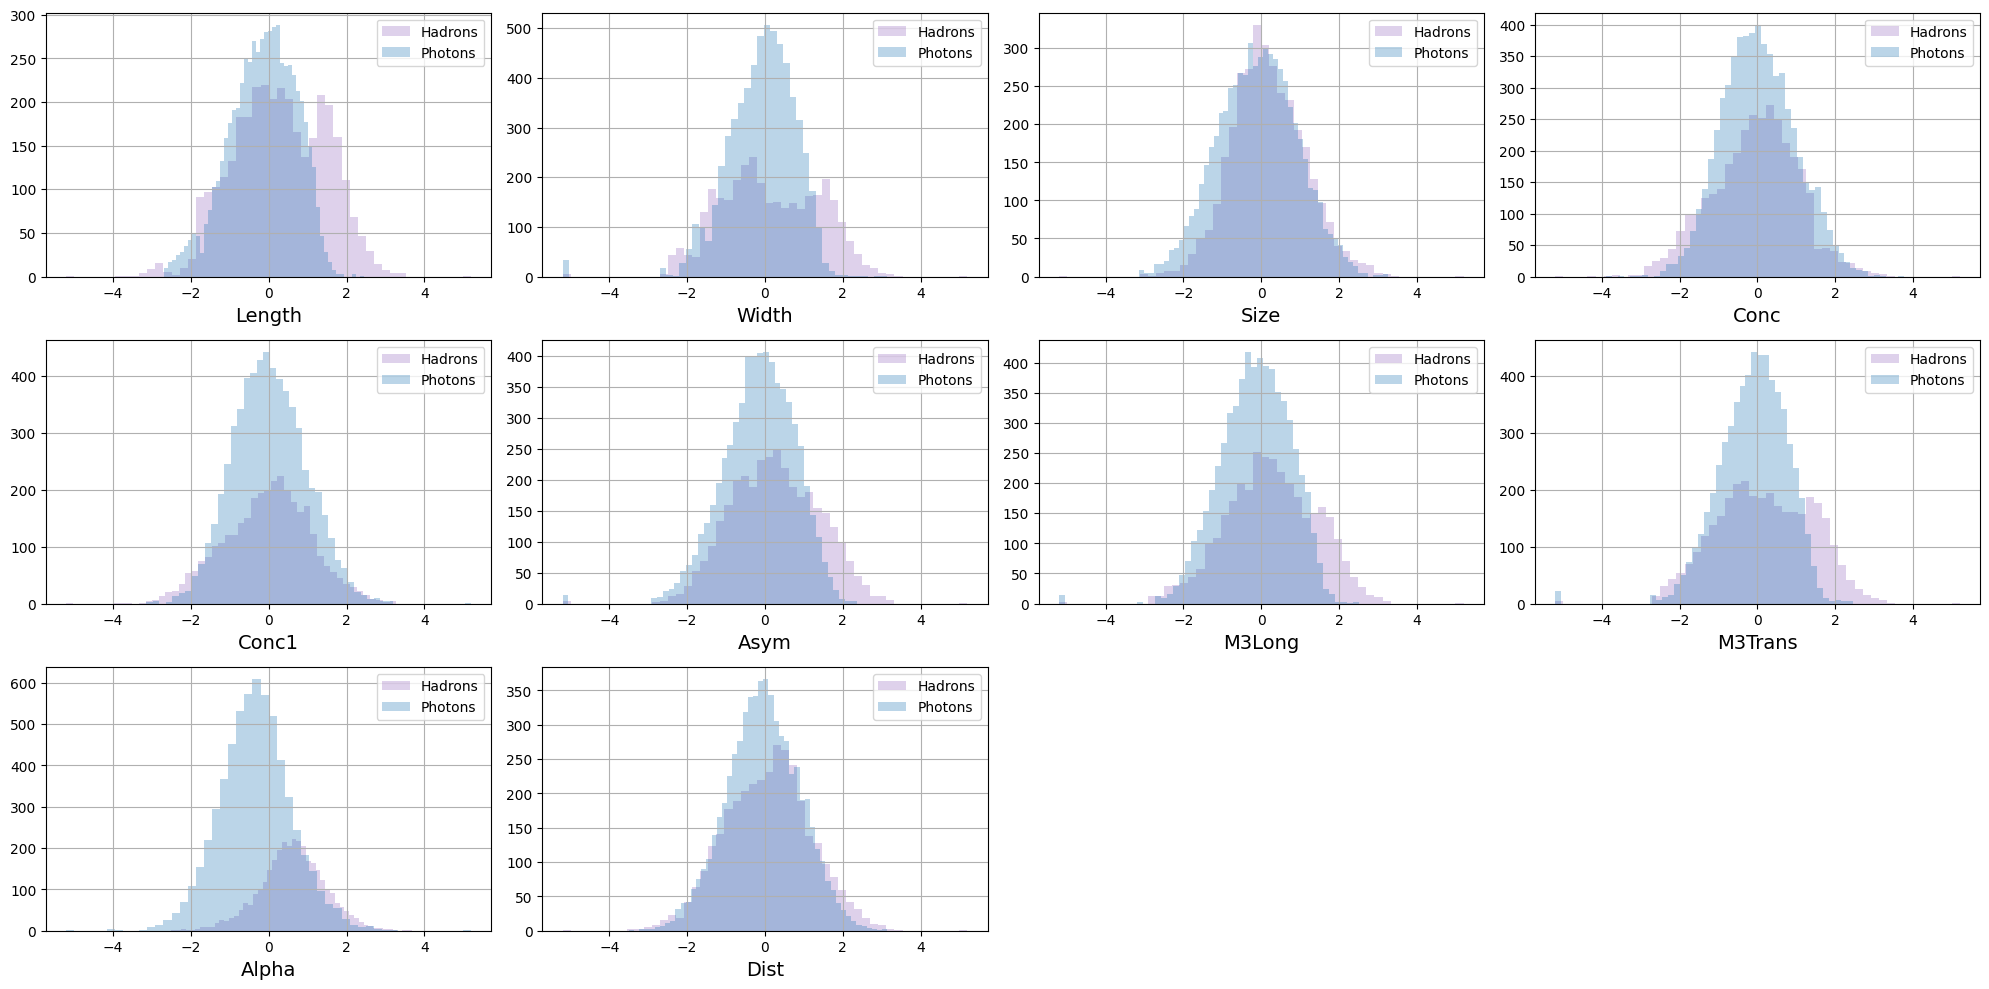

In [65]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

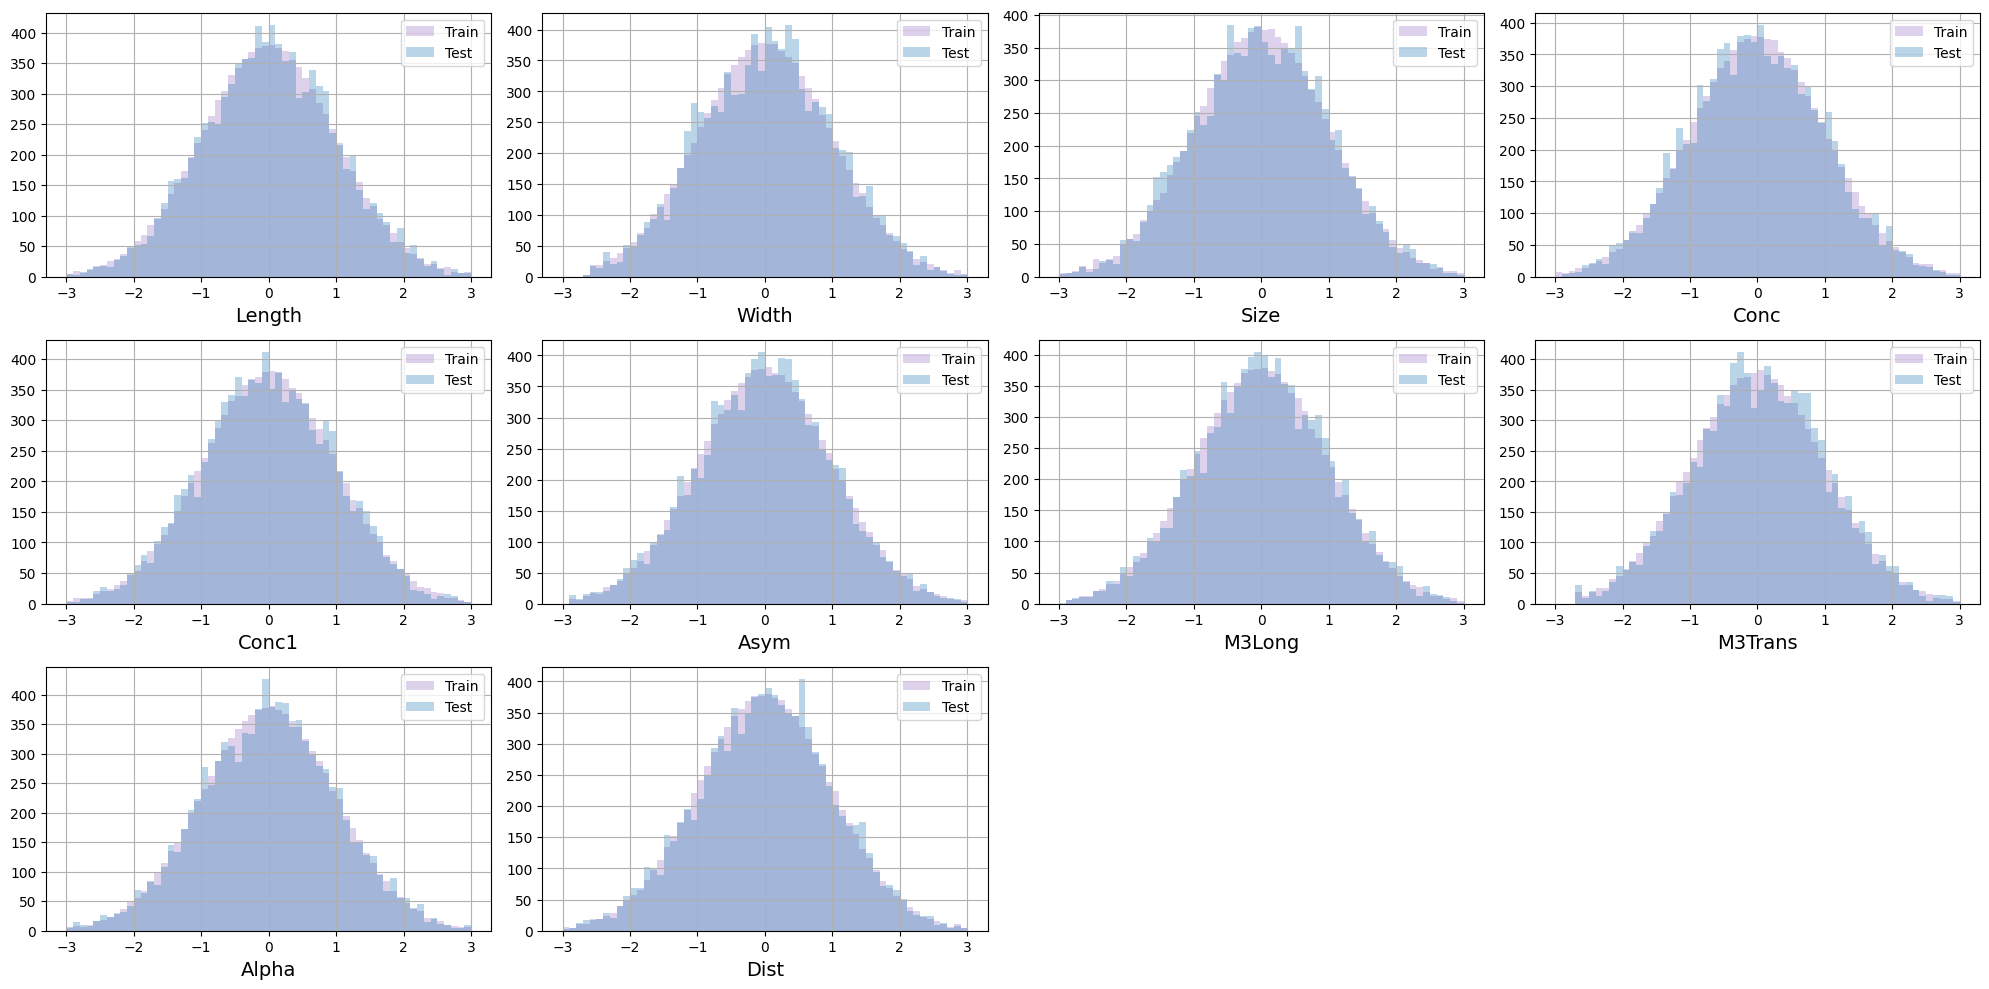

In [66]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [69]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.lin1 = nn.Linear(n_inputs, 100)
        self.batch1 = nn.BatchNorm1d(100)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(100, 100)
        self.batch2 = nn.BatchNorm1d(100)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(100, n_outputs)

    def forward(self, z, y):
        y = torch.tensor(y, dtype=torch.float, device=DEVICE)
        zy = torch.cat((z, y), dim=1)
        
        x = self.lin1(zy)
        x = self.batch1(x)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        output = self.output(x)
        return output

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [70]:
def generate(generator, y, latent_dim):
    noise = torch.randn(y.shape[0], latent_dim).to(DEVICE)
 
    with torch.no_grad():
        X_fake = generator.forward(noise, y)

    X_fake = X_fake.cpu().numpy()
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

* Нашла ответ в этом обсуждении: https://github.com/GunhoChoi/LSGAN-TF/issues/1.
* После последнего полносвязного слоя функция активации отсутствует.
* Избавляются от сигмовидной функции активации на последнем слое для лучшего свойства сходимости. 
* Выбор последнего слоя в качестве линейного даст лучшую производительность.

In [71]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.lin1 = nn.Linear(n_inputs, 100)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(100, 100)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(100, 1)

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        
        x = self.lin1(xy)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        output = self.output(x)
        
        return output

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [73]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)
    
    #This stratify parameter makes a split so that the proportion of values in the sample 
    #produced will be the same as the proportion of values provided by parameter stratify.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)
    
    reg = LogisticRegression()
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_test)
    
    boost = GradientBoostingClassifier()
    boost.fit(X_train, y_train)
    boost_pred = boost.predict(X_test)
    
    lin_reg_score = accuracy_score(reg_pred, y_test)
    boosting_score = accuracy_score(boost_pred, y_test)
    
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [74]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE) 

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                # discriminator
                for _ in range(self.n_critic):
                    self.opt_disc.zero_grad()
                    Z_noise = torch.randn((len(real_batch), self.latent_dim)).to(DEVICE)
                    X_fake = self.generator(Z_noise, cond_batch)
                    loss_disc = -torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(
                        self.discriminator(X_fake, cond_batch))
                    loss_disc.backward()
                    self.opt_disc.step()

                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                # generator
                self.opt_gen.zero_grad()
                Z_noise = torch.randn((len(real_batch), self.latent_dim)).to(DEVICE)
                X_fake = self.generator(Z_noise, cond_batch)
                gen_loss = -torch.mean(self.discriminator(X_fake, cond_batch))
                gen_loss.backward()
                self.opt_gen.step()

            # calculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = -torch.mean(self.discriminator(X_real, y_cond)) + torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            fake_samples = generate(self.generator, y_cond[:1000], self.latent_dim)
            real_samples = X_real[:1000].cpu().numpy()

            other_agent_score(real_samples, np.ones(len(real_samples)), 
                              fake_samples, np.zeros(len(fake_samples)))
            print(f"epoch {epoch}, loss = {loss_epoch}")

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [75]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.56
Boosting score: 0.72
epoch 0, loss = -0.0006668390706181526
Linear regression score: 0.5583333333333333
Boosting score: 0.675
epoch 1, loss = -0.000380135141313076
Linear regression score: 0.525
Boosting score: 0.6566666666666666
epoch 2, loss = -2.551637589931488e-05
Linear regression score: 0.49333333333333335
Boosting score: 0.6466666666666666
epoch 3, loss = -2.279132604598999e-05
Linear regression score: 0.53
Boosting score: 0.6333333333333333
epoch 4, loss = -7.756613194942474e-05
Linear regression score: 0.485
Boosting score: 0.595
epoch 5, loss = -0.00015697535127401352
Linear regression score: 0.5366666666666666
Boosting score: 0.655
epoch 6, loss = 7.026363164186478e-05
Linear regression score: 0.5333333333333333
Boosting score: 0.6033333333333334
epoch 7, loss = 8.607655763626099e-05
Linear regression score: 0.5933333333333334
Boosting score: 0.6033333333333334
epoch 8, loss = 0.00017279665917158127
Linear regression score: 0.53
Boosting score: 

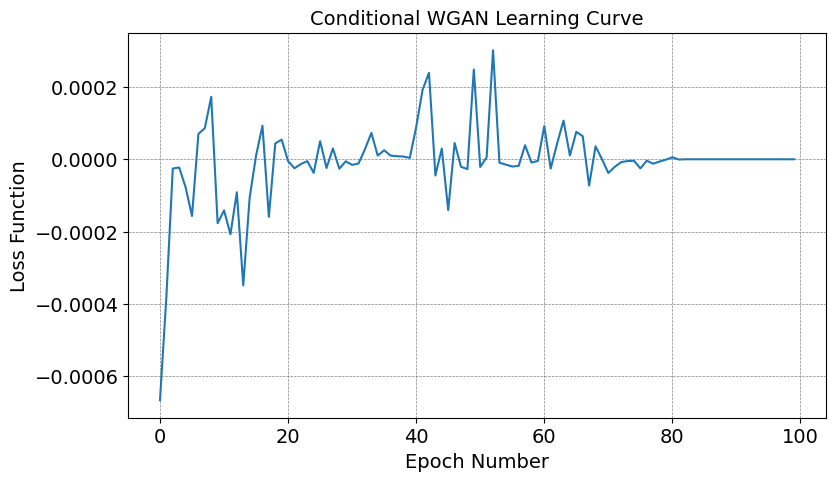

In [76]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [77]:
X_train_1 = qt.inverse_transform(X_train)
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train)

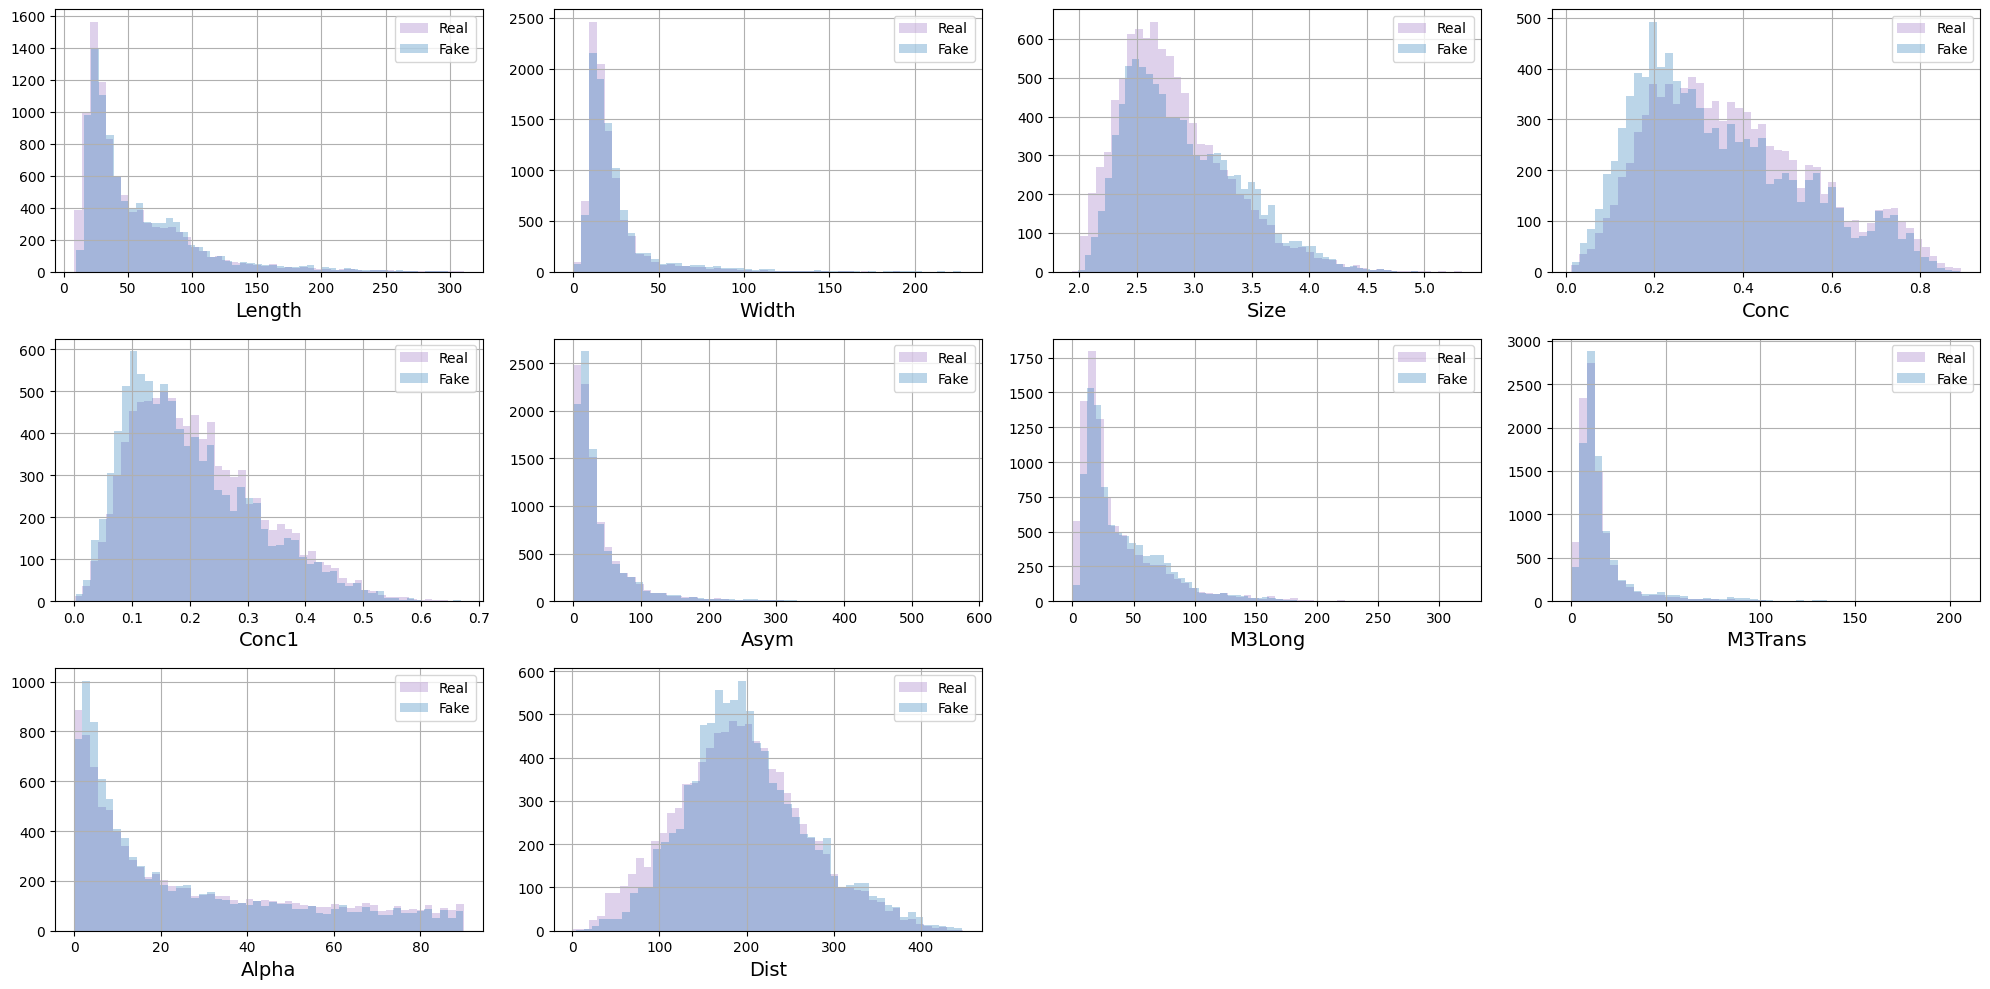

In [78]:
plot_hists(X_train_1, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [79]:
X_test_1 = qt.inverse_transform(X_test)
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test)

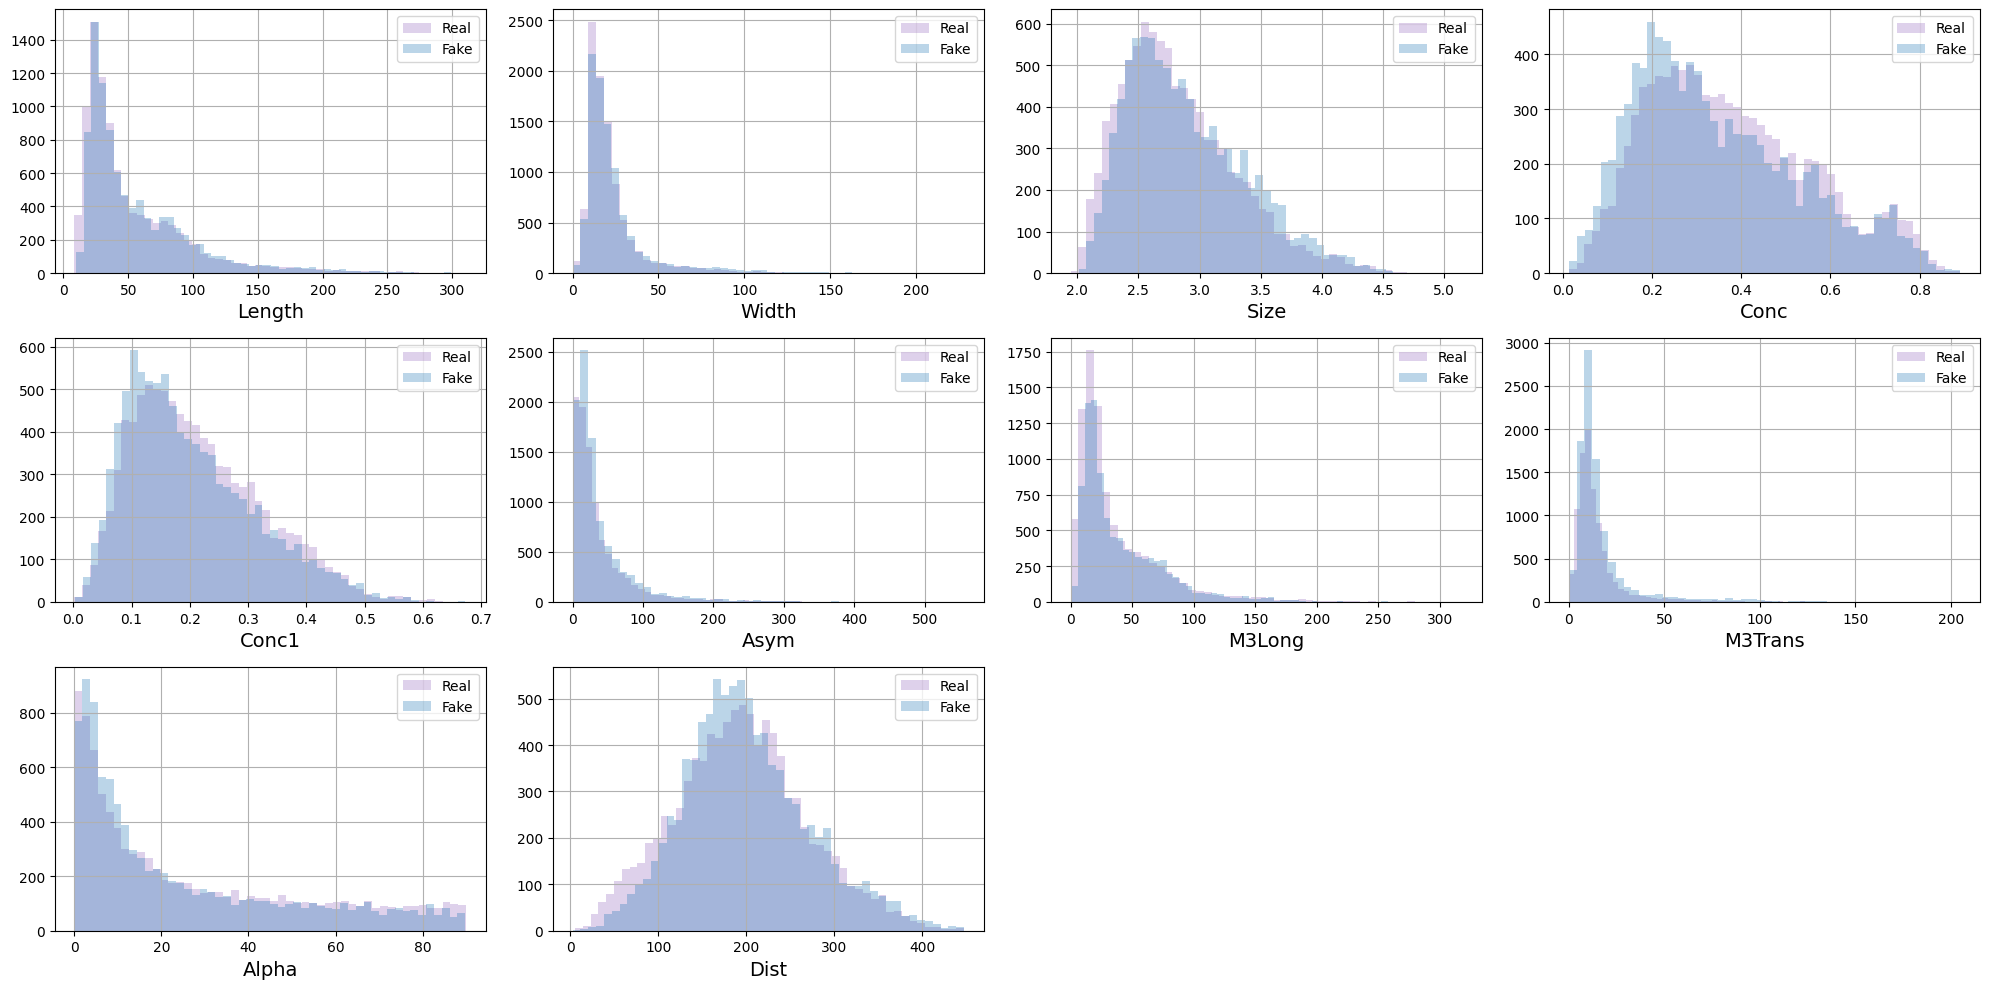

In [80]:
plot_hists(X_test_1, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [81]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_1), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_1), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_1))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_1))

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [83]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7402201954663916


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


* Исходя из графиков можно сказать, что наблюдается сходство между реальными и фейковыми данными. 
* Boosting score выше, чем Linear regression score, так как такая модель более сложная, способна видеть нелинейные связи.
* ROC AUC достаточно неплохой, но можно было бы и лучше, конечно, но это хотя бы выше 0.5. Если ROC AUC, это означает, что предсказания модели являются случайными.


## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [84]:
#print(X_train.shape[1]) -> 10

In [85]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 10, 1, 1)
    return x * (1 - amount) + noise * amount

In [86]:
!pip install diffusers -q
from diffusers import DDPMScheduler

## Добавим sсheduler, он пригодится вам при обучении модели

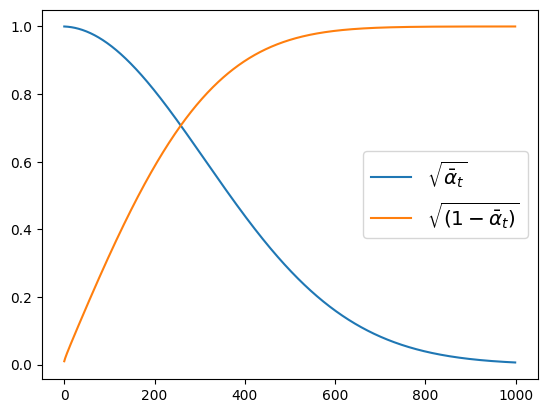

In [87]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [88]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.lin1 = nn.Linear(n_inputs, 100)
        self.batch1 = nn.BatchNorm1d(100)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(100, 100)
        self.batch2 = nn.BatchNorm1d(100)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(100, n_outputs)

    def forward(self, z, y):
        y = torch.tensor(y, dtype=torch.float, device=DEVICE)
        zy = torch.cat((z, y), dim=1)
        
        x = self.lin1(zy)
        x = self.batch1(x)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        output = self.output(x)
        return output

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [89]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    model.eval()
    noise = torch.randn(y.shape[0], latent_dim).to(DEVICE)
    
    with torch.no_grad():
        X_fake = model.forward(noise, y)
    #fron seminar
    noise_1 = torch.randn_like(X_fake)
    timesteps = torch.linspace(0, 999, y.shape[0]).long().to(DEVICE)
    X_fake = noise_scheduler.add_noise(X_fake, noise_1, timesteps)
    X_fake = X_fake.cpu().numpy()
    
    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [90]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        #from the seminar
        loss_fn = nn.MSELoss()

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                self.opt_gen.zero_grad()
                #from the seminar
                noise = torch.randn_like(real_batch)
                timesteps = torch.linspace(0, 999, real_batch.shape[0]).long().to(DEVICE)
                #same as previous model
                Z_noise = torch.randn((len(real_batch), self.latent_dim)).to(DEVICE)
                X_fake = self.model(Z_noise, cond_batch)
                
                X_fake_with_noisy = noise_scheduler.add_noise(X_fake, noise, timesteps)
                loss = loss_fn(X_fake_with_noisy, noise)
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            fake_samples = generate_with_diffusion(self.model, y_cond[:1000],
                                                   self.latent_dim, noise_scheduler)
            real_samples = X_real[:1000].cpu().numpy()

            other_agent_score(real_samples, np.ones(len(real_samples)), 
                              fake_samples, np.zeros(len(fake_samples)))
            print(f"Epoch {epoch} loss = {loss_epoch}")

        # Turn off training
        self.model.train(False)

In [91]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.49333333333333335
Boosting score: 0.8566666666666667
Epoch 0 loss = 40.276356399059296
Linear regression score: 0.46166666666666667
Boosting score: 0.8866666666666667
Epoch 1 loss = 27.494657188653946
Linear regression score: 0.4866666666666667
Boosting score: 0.9016666666666666
Epoch 2 loss = 24.972831152379513
Linear regression score: 0.48
Boosting score: 0.8933333333333333
Epoch 3 loss = 25.02129102498293
Linear regression score: 0.5433333333333333
Boosting score: 0.8833333333333333
Epoch 4 loss = 24.078560657799244
Linear regression score: 0.49333333333333335
Boosting score: 0.8933333333333333
Epoch 5 loss = 23.542873568832874
Linear regression score: 0.47333333333333333
Boosting score: 0.875
Epoch 6 loss = 23.805934391915798
Linear regression score: 0.51
Boosting score: 0.8616666666666667
Epoch 7 loss = 24.025345273315907
Linear regression score: 0.4866666666666667
Boosting score: 0.905
Epoch 8 loss = 23.613007701933384
Linear regression score: 0.5016666

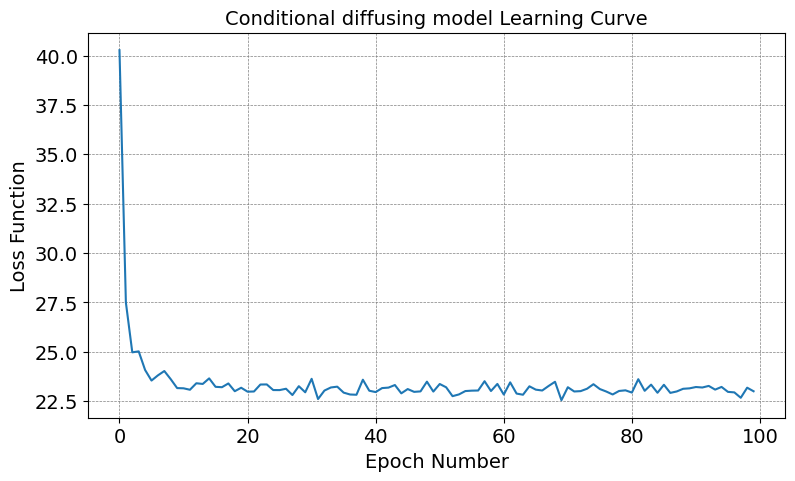

In [92]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [93]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, noise_scheduler)
X_fake_train = qt.inverse_transform(X_fake_train)

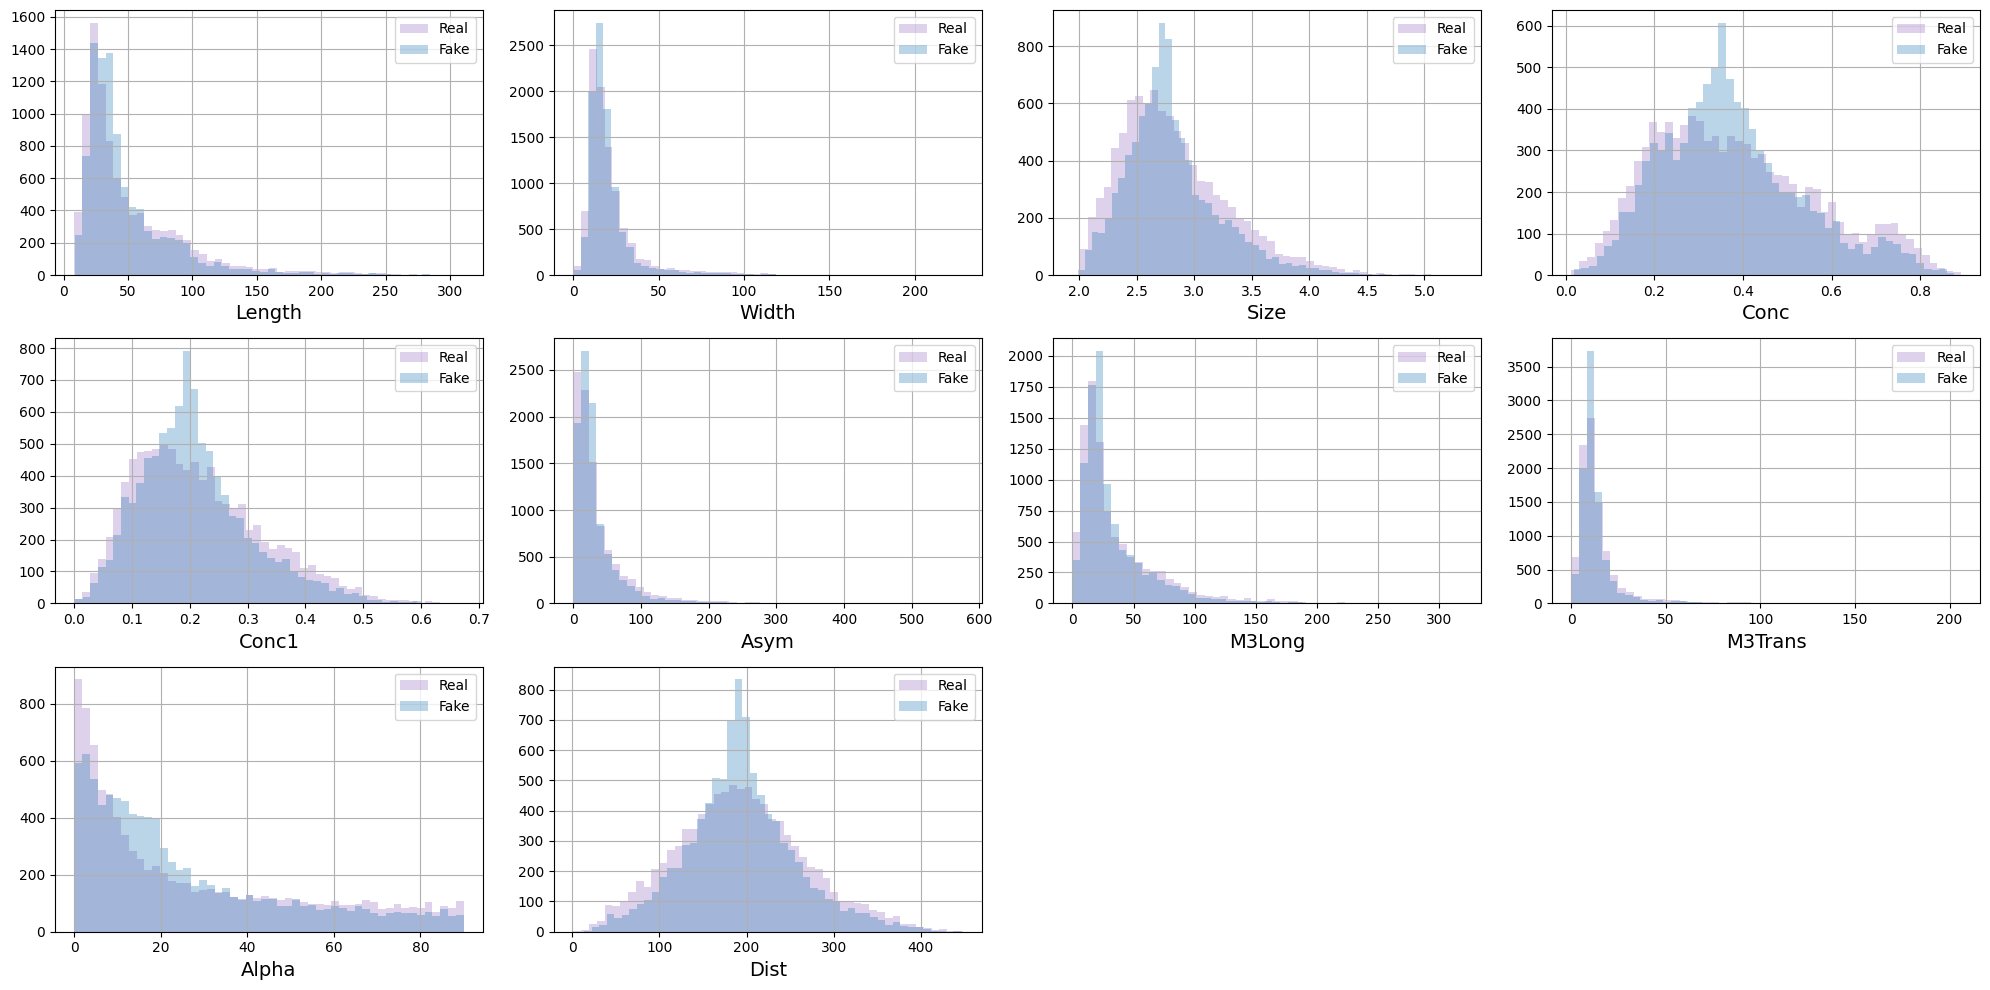

In [94]:
plot_hists(X_train_1, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [95]:
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, noise_scheduler)
X_fake_test = qt.inverse_transform(X_fake_test)

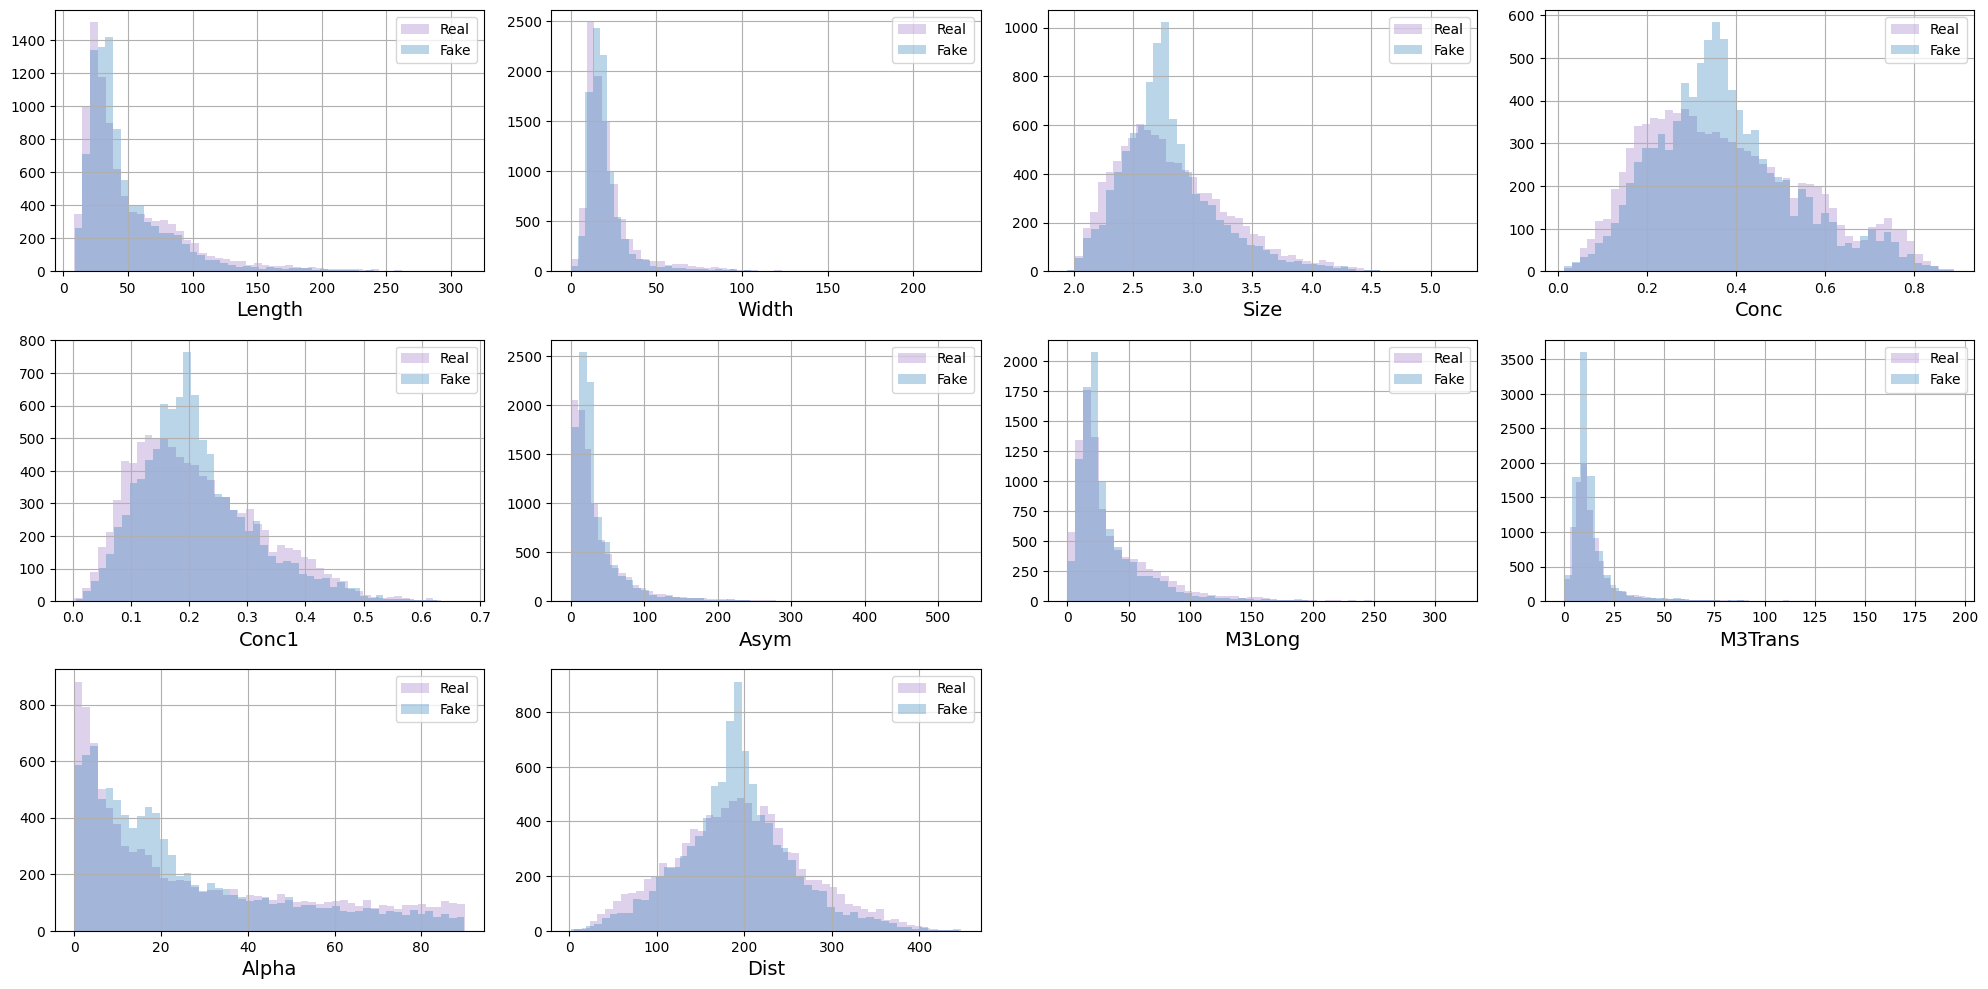

In [96]:
plot_hists(X_test_1, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [97]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_1), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_1), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_1))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_1))

In [98]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [99]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.9781288167527458


In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
yy_test_pred = clf.predict(XX_test)
accur = accuracy_score(yy_test, yy_test_pred)
prec = precision_score(yy_test, yy_test_pred)
recall = recall_score(yy_test, yy_test_pred)
print(f"Accuracy = {accur}\nPrecision = {prec}\nRecall = {recall}")

Accuracy = 0.9228706624605678
Precision = 0.9234495103716963
Recall = 0.9221871713985279


* Качество Diffusion Generator выше (ROC AUC = 0.98), что является достаточно хорошим результатом.
* Исходя из графиков можно сказать, что наблюдается высокое сходство между реальными и фейковыми данными. 
* Boosting score выше, чем Linear regression score (как и в WGAN).
* Accuracy, Precision, Recall также достаточно высокие.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!